In [ ]:
!pip install rouge_score
!pip uninstall pyarrow -y
!pip uninstall datasets -y
!pip install pyarrow==10.0.1 datasets==2.4.0
!pip install py7zr
!pip install transformers nltk
!pip install datasets transformers
!pip install wandb
!pip install accelerate -U
!pip install transformers[torch]

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=7732122ecf9bc2bed5c3040ee9dec298009c45d8ca2958eba2c2a4853bc9ad4f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could tak

In [ ]:
!git clone https://github.com/ryanzhumich/AESLC

Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (18304/18304), done.


In [ ]:
import os
import pandas as pd

In [ ]:
def load_data_from_directory(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".subject"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    subject = f.readline().strip()
                    email_body = f.read().strip()
                    data.append({'subject_line': subject, 'email_body': email_body})
    return pd.DataFrame(data)

train_data = load_data_from_directory('/content/AESLC/enron_subject_line/train')
dev_data = load_data_from_directory('/content/AESLC/enron_subject_line/dev')
test_data = load_data_from_directory('/content/AESLC/enron_subject_line/test')

In [ ]:
train_data.head()

,subject_line,email_body
0,Sam: We need to send Sharen Cason the Deemed ...,It is a domestic deal and I'd like to review y...
1,"Patrick, The attached file contains the base...",Let me know if you have any questions.\nD\n\n@...
2,FYI: One of our legal consultants has mentione...,They are using an outfit called Intuitive Pro...
3,"Marc, Here's a draft reply to your latest e-m...","What do you think?\nMarc, We have sought, and..."
4,"Richard, I would like to inform you that we ...",Thanks for your interest in having Enron invo...


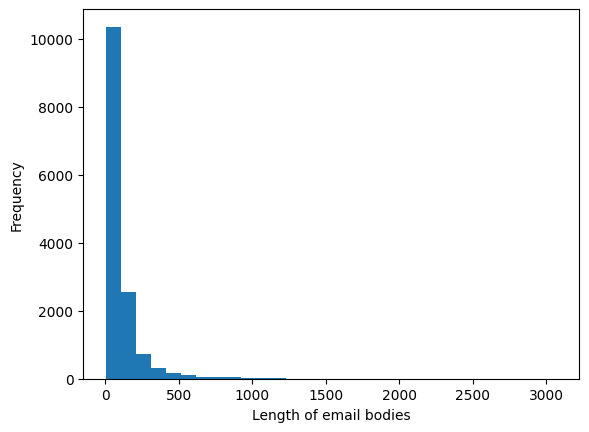

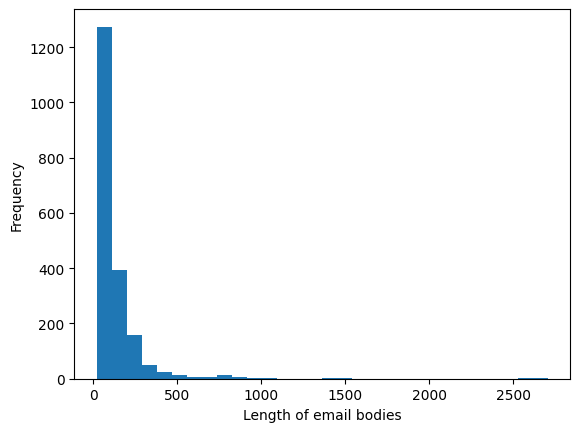

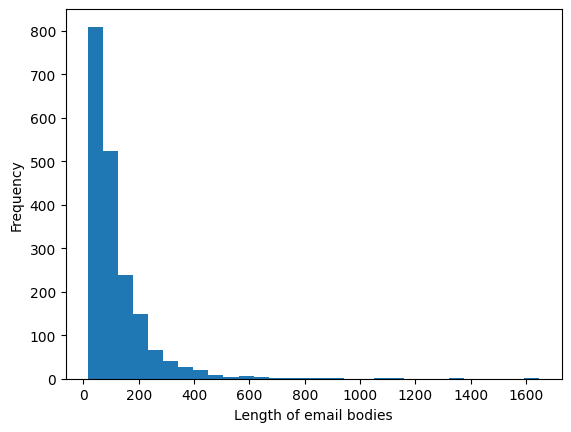

In [ ]:
import matplotlib.pyplot as plt

def plot_data(data):
    lengths = [len(text.split()) for text in data['email_body']]
    plt.hist(lengths, bins=30)
    plt.xlabel('Length of email bodies')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_data)
plot_data(dev_data)
plot_data(test_data)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('qwen/qwen-7b')

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers_stream_generator einops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
  Created wheel for transformers_stream_generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12425 sha256=d8e94e839f8817a7207f72d45c87982ac50bf3af1f2cb1feb12b80c8030b4a91
  Stored in directory: /root/.cache/pip/wheels/95/4a/90/140f7b67d125906f6a165f38aad212ecb4a695ad0d87582437
Successfully built transformers_stream_generator


In [ ]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Custom dataset class
class EmailSubjectDataset(Dataset):
    def __init__(self, emails, subjects, tokenizer, max_length):
        self.emails = emails
        self.subjects = subjects
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        email_text = self.emails[idx]
        subject_text = self.subjects[idx]

        # Tokenize inputs and outputs
        inputs = self.tokenizer(email_text, return_tensors='pt', max_length=self.max_length, truncation=True,
                                padding='max_length')
        outputs = self.tokenizer(subject_text, return_tensors='pt', max_length=self.max_length, truncation=True,
                                 padding='max_length')

        return {
            'input_ids': inputs.input_ids.flatten(),
            'attention_mask': inputs.attention_mask.flatten(),
            'labels': outputs.input_ids.flatten()
        }

# Directory containing email files
emails_directory = './AESLC/enron_subject_line/train'




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('qwen/qwen-7b')
tokenizer.pad_token = tokenizer.eos_token  # Ensure padding token is set



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

The repository for qwen/qwen-7b contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/qwen/qwen-7b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tokenization_qwen.py:   0%|          | 0.00/9.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/qwen/qwen-7b:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


qwen.tiktoken:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

In [ ]:
# Load emails and subjects from files
emails = []
subjects = []

for filename in os.listdir(emails_directory):
    with open(os.path.join(emails_directory, filename), 'r', encoding='utf-8', errors='ignore') as file:
        email_text = file.read()
        # Extract subject from email body using regex
        match = re.search(r'@subject\s+(.*)', email_text, re.IGNORECASE | re.DOTALL)

        if match:
            subject = match.group(1).strip()
            email_body = re.sub(r'@subject\n(.+)\n', '', email_text).strip()
            preprocessed_email = preprocess_text(email_body)

            emails.append(preprocessed_email)
            subjects.append(subject)

# Create dataset
print(emails[0])
print(subjects[0])
dataset = EmailSubjectDataset(emails, subjects, tokenizer, max_length=512)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="epoch",
)

# Initialize model
model = AutoModelForCausalLM.from_pretrained('qwen/qwen-7b')

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Fine-tuning the model
trainer.train()

sam need send sharen cason deemed isda format reconfirm transaction domestic deal like review template sending sharen please email monday send sharen thanks sara subject cargill alliant financial deal
Cargill Alliant financial deal # 495432.01


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

The repository for qwen/qwen-7b contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/qwen/qwen-7b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


configuration_qwen.py:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/qwen/qwen-7b:
- configuration_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for qwen/qwen-7b contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/qwen/qwen-7b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling_qwen.py:   0%|          | 0.00/55.6k [00:00<?, ?B/s]

cpp_kernels.py:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/qwen/qwen-7b:
- cpp_kernels.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


qwen_generation_utils.py:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/qwen/qwen-7b:
- qwen_generation_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/qwen/qwen-7b:
- modeling_qwen.py
- cpp_kernels.py
- qwen_generation_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.96G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]